### Dataset normalisation

In [ ]:
import pandas as pd

def normalize_suites(df):
    """
    Collapse multiple rows of 'unit' (collectstatic, migrate, unit-tests, retries)
    and 'functional' (if split) into ONE row per (pipeline_id, tag, mode).
    Non-test rows (build, lint, etc.) are preserved.
    Keeps row order by timestamp.
    """
    test_tags = ["unit", "functional"]

    # Separate suites vs other jobs
    test_df = df[df["tag"].isin(test_tags)].copy()
    other_df = df[~df["tag"].isin(test_tags)].copy()

    if test_df.empty:
        return df.sort_values("timestamp")

    # Aggregate per pipeline_id + tag + mode
    agg_test = (
        test_df.groupby(["pipeline_id","tag","mode"]).agg({
            "duration_s": "sum",    # total duration of all sub-steps
            "cpu_pct_avg": "mean",  # average CPU usage
            "mem_kb_max": "max",    # peak memory
            "exit_code": "max",     # any nonzero -> fail
            "status": lambda s: (
                "fail" if (s=="fail").any()
                else "skipped" if (s=="skipped").any()
                else "pass"
            ),
            "timestamp": "min",     # earliest timestamp among sub-steps
            "command": lambda s: ";".join(s)  # join commands for traceability
        }).reset_index()
    )

    # Merge back
    merged = pd.concat([other_df, agg_test], ignore_index=True)

    # Ensure chronological order
    merged = merged.sort_values(["pipeline_id","timestamp"]).reset_index(drop=True)

    return merged

df = pd.read_csv("intelligent_test_selection_pre_norm.csv")
df_norm = normalize_suites(df)

print("Before:", df.shape, "After normalization:", df_norm.shape)
df_norm.head(15)

# df_norm.to_csv("intelligent_test_selection.csv", index=False)


Before: (191, 10) After normalization: (146, 10)


In [142]:
import pandas as pd

df = pd.read_csv("all_logs_pre_norm.csv")

# Step 1: Map test tags
def map_tag(row):
    if row["tag"] == "test":
        cmd = row["command"]
        if "--exclude-tag=functional" in cmd:
            return "unit"
        elif "--tag=functional" in cmd:
            return "functional"
        elif "collectstatic" in cmd or "migrate" in cmd:
            return "unit"
    return row["tag"]

df["tag"] = df.apply(map_tag, axis=1)

# Step 2: Split into test vs non-test
test_df = df[df["tag"].isin(["unit","functional"])].copy()
non_test_df = df[~df["tag"].isin(["unit","functional"])].copy()

# Step 3: Aggregate only test jobs
agg_test = (test_df.groupby(["pipeline_id","tag","mode"])
         .agg({
             "timestamp":"first",
             "command": lambda x: ";".join(x),
             "duration_s":"sum",
             "exit_code":"max",
             "cpu_pct_avg":"mean",
             "mem_kb_max":"max",
             "status": lambda x: "fail" if "fail" in x.values else "pass"
         })
         .reset_index())

# Step 4: Reorder columns
agg_test = agg_test[["timestamp","command","duration_s","exit_code",
                     "cpu_pct_avg","mem_kb_max","tag","status","pipeline_id","mode"]]

non_test_df = non_test_df[["timestamp","command","duration_s","exit_code",
                           "cpu_pct_avg","mem_kb_max","tag","status","pipeline_id","mode"]]

# Step 5: Merge back together
normalized = pd.concat([non_test_df, agg_test]).sort_values(by=["timestamp"]).reset_index(drop=True)

# normalized.to_csv("all_logs.csv", index=False)
print("Before:", df.shape, "After:", normalized.shape)


Before: (606, 10) After: (427, 10)


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("all_logs.csv")

# Count before
before = len(df)

# Drop duplicates
df = df.drop_duplicates()

# Count after
after = len(df)

print(f"Rows before: {before}")
print(f"Rows after : {after}")
print(f"Removed    : {before - after}")

# Save back (optional)
# df.to_csv("all_logs.csv", index=False)

In [ ]:
df2 = pd.read_csv("intelligent_test_selection.csv")
print("Before:", len(df2))
df2 = df2.drop_duplicates()
print("After :", len(df2))
print("Removed:", len(df2))
#df2.to_csv("intelligent_test_selection.csv", index=False)


### generate healing_outcomes.csv from your existing dataset

In [ ]:

import pandas as pd

# Load your existing dataset
df = pd.read_csv("../data/post_healing/intelligent_test_selection.csv")

# Container for healing outcomes
rows = []

for _, row in df.iterrows():
    ts = row["timestamp"]
    mode = row["mode"]
    tag = row["tag"].strip().lower()
    status = str(row["status"]).lower()
    command = str(row["command"]).lower()

    # --- Retry detection (baseline vs ml) ---
    if "retry" in command:  # e.g. lint-retry, unit-tests-retry
        action = "retry" if mode == "baseline" else "rf-retry"
        result = "success" if status == "pass" else "fail"
        rows.append([ts, tag, mode, action, result])

    # --- Skip detection ---
    if status == "skipped":
        rows.append([ts, tag, mode, "skip", "success"])  # optimistic default

# --- LSTM abort detection ---
for pid, g in df.groupby("pipeline_id"):
    if ((g["tag"] == "lint") & (g["status"] == "fail")).any():
        if not ((g["tag"].isin(["unit","functional"])) & (g["status"].isin(["pass","fail"]))).any():
            lint_fail = g[(g["tag"]=="lint") & (g["status"]=="fail")].iloc[-1]
            rows.append([lint_fail["timestamp"], "lint", lint_fail["mode"], "lstm-abort", "fail"])

# Build outcomes DataFrame
outcomes = pd.DataFrame(rows, columns=["timestamp","tag","mode","action","result"])
outcomes = outcomes.sort_values("timestamp")

# Save to CSV
outcomes.to_csv("../logs/healing_outcomes.csv", index=False)

# --- Summary statistics ---
summary = (
    outcomes
    .groupby("action")
    .agg(
        total=("result", "count"),
        successes=("result", lambda x: (x == "success").sum())
    )
)
summary["success_rate"] = (summary["successes"] / summary["total"] * 100).round(1)

print(f"Extracted {len(outcomes)} healing outcomes")
display(outcomes.head(20))
display(summary)

Extracted 51 healing outcomes


,timestamp,tag,mode,action,result
44,2025-06-26 14:34:37,lint,ml,lstm-abort,fail
45,2025-07-13 07:53:21,lint,baseline,lstm-abort,fail
46,2025-07-13 07:53:27,lint,baseline,lstm-abort,fail
47,2025-07-13 07:54:18,lint,baseline,lstm-abort,fail
48,2025-08-01 06:53:32,lint,baseline,lstm-abort,fail
49,2025-08-01 08:30:23,lint,baseline,lstm-abort,fail
50,2025-08-01 08:51:30,lint,baseline,lstm-abort,fail
0,2025-08-21 23:45:35,lint,ml,rf-retry,fail
1,2025-08-22 00:33:00,lint,ml,rf-retry,fail
2,2025-08-22 01:07:22,lint,ml,rf-retry,fail


,total,successes,success_rate
action,,,
lstm-abort,7,0,0.0
retry,14,10,71.4
rf-retry,3,0,0.0
skip,27,27,100.0


total  successes  success_rate
action     mode                                    
lstm-abort baseline      6          0           0.0
           ml            1          0           0.0
retry      baseline     14         10          71.4
rf-retry   ml            3          0           0.0
skip       baseline      1          1         100.0
           ml           26         26         100.0

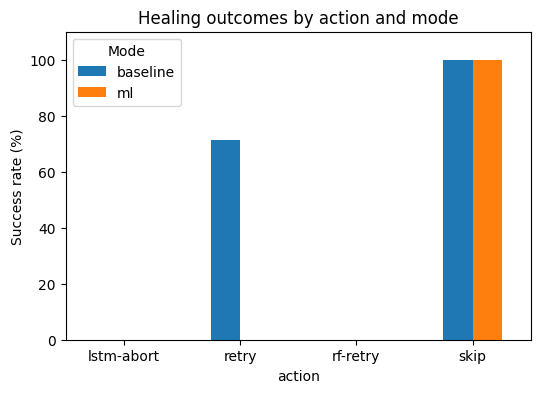

In [14]:
import matplotlib.pyplot as plt

# Build summary table
summary = (
    outcomes
    .groupby(["action","mode"])
    .agg(
        total=("result","count"),
        successes=("result", lambda x: (x=="success").sum())
    )
)
summary["success_rate"] = (summary["successes"]/summary["total"]*100).round(1)

display(summary)

# --- Plot ---
fig, ax = plt.subplots(figsize=(6,4))
summary.reset_index().pivot(index="action", columns="mode", values="success_rate").plot(
    kind="bar", ax=ax
)
plt.ylabel("Success rate (%)")
plt.title("Healing outcomes by action and mode")
plt.xticks(rotation=0)
plt.ylim(0, 110)
plt.legend(title="Mode")
plt.show()


### minimal RL prototype plan to showcase adaptive self-healing with reinforcement learning explorationwith

In [9]:
# rl_adaptive_healing.ipynb

# --- Setup ---
# pip install stable-baselines3 gym pandas numpy

import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO

# --- Load your logs ---
logs_df = pd.read_csv("../data/post_healing/intelligent_test_selection.csv")

# Ensure required columns exist
required = {"duration_s","cpu_pct_avg","mem_kb_max","exit_code","tag","status"}
assert required.issubset(logs_df.columns), f"Missing columns: {required - set(logs_df.columns)}"


# --- Define RL Environment ---
class HealEnv(gym.Env):
    """
    Environment for adaptive CI/CD healing
    States are derived from job logs
    Actions are retry/abort/continue/skip
    Rewards simulate time/resource trade-offs
    """
    def __init__(self, logs_df):
        super().__init__()
        self.logs = logs_df.sample(frac=1).reset_index(drop=True)  # shuffle
        self.idx = 0

        # 4 discrete actions: retry, abort, continue, skip
        self.action_space = spaces.Discrete(4)

        # Observations: duration, cpu, mem, exit_code, tag_code, status_flag
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(6,), dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.idx = 0
        return self._get_state(), {}

    def _get_state(self):
        row = self.logs.iloc[self.idx]
        tag_map = {"lint":0, "unit":1, "functional":2, "test":3}
        return np.array([
            min(row["duration_s"]/100, 1.0),
            min(row["cpu_pct_avg"]/100, 1.0),
            min(row["mem_kb_max"]/1e6, 1.0),
            float(row["exit_code"] != 0),   # 1 if fail, 0 if pass
            tag_map.get(row["tag"], -1)/3, # normalize to [0,1]
            1.0 if row["status"]=="pass" else 0.0
        ], dtype=np.float32)

    def step(self, action):
        row = self.logs.iloc[self.idx]
        reward, terminated, truncated = 0, False, False

        if action == 0:   # retry
            if row["status"]=="fail":
                reward = np.random.choice([1.0, -0.5], p=[0.4, 0.6])
            else:
                reward = -0.2
        elif action == 1: # abort
            reward = 0.3 if row["status"]=="fail" else -1.0
            terminated = True
        elif action == 2: # continue
            reward = 1.0 if row["status"]=="pass" else -1.0
        elif action == 3: # skip
            reward = 0.2

        self.idx += 1
        if self.idx >= len(self.logs):
            terminated = True

        return self._get_state(), reward, terminated, truncated, {}

# Train RL Agent
env = HealEnv(logs_df)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=5000)

# Save agent
model.save("adaptive_heal_rl")

# evaluate with the VecEnv (the same one you trained with)
# obs = env.reset()
# total_reward = 0
# for _ in range(50):
    # action, _ = model.predict(obs)
    # obs, rewards, dones, infos = env.step(action)
    # total_reward += rewards[0]  # rewards is a vector (since DummyVecEnv)
    # if dones[0]:
        # obs = env.reset()

# evaluate on a raw HealEnv (single env)
eval_env = HealEnv(logs_df)
obs, info = eval_env.reset()
total_reward = 0
for _ in range(50):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    total_reward += reward
    if terminated or truncated:
        obs, info = eval_env.reset()

print("Average simulated reward:", total_reward/50)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.13     |
|    ep_rew_mean     | -0.104   |
| time/              |          |
|    fps             | 1089     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.96        |
|    ep_rew_mean          | 0.419       |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020726845 |
|    clip_fraction        | 0.533       |
|    clip_range           | 0.2         |
|    entropy_loss   

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.08     |
|    ep_rew_mean     | 0.029    |
| time/              |          |
|    fps             | 1053     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5.25        |
|    ep_rew_mean          | 0.486       |
| time/                   |             |
|    fps                  | 660         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.032429826 |
|    clip_fraction        | 0.467       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_varia

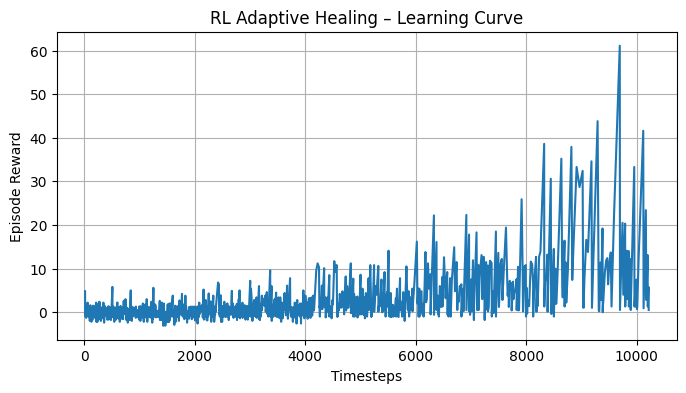

In [12]:
import os
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

# Folder where Monitor logs are saved
log_dir = "./adaptive_heal_rl"
os.makedirs(log_dir, exist_ok=True)

# Wrap environment with Monitor (for logging rewards)
env = HealEnv(logs_df)
env = Monitor(env, log_dir)

# Train with logging
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Load rewards from Monitor logs
x, y = ts2xy(load_results(log_dir), "timesteps")

plt.figure(figsize=(8,4))
plt.plot(x, y)
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.title("RL Adaptive Healing – Learning Curve")
plt.grid(True)
plt.show()

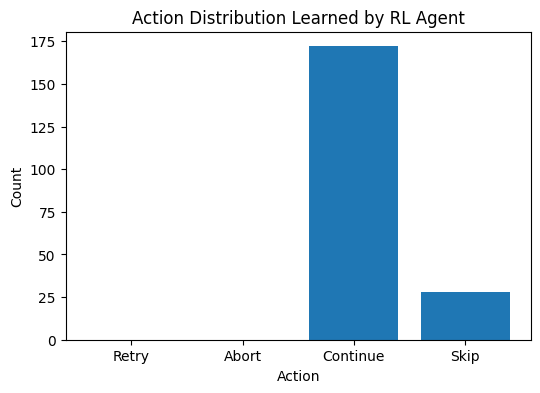

In [13]:
import numpy as np

actions_taken = []

eval_env = HealEnv(logs_df)
obs, info = eval_env.reset()
for _ in range(200):  # simulate 200 jobs
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    actions_taken.append(action)
    if terminated or truncated:
        obs, info = eval_env.reset()

# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(actions_taken, bins=np.arange(-0.5,4.5,1), rwidth=0.8)
plt.xticks([0,1,2,3], ["Retry","Abort","Continue","Skip"])
plt.xlabel("Action")
plt.ylabel("Count")
plt.title("Action Distribution Learned by RL Agent")
plt.show()
